# Projet Econométrie Partie 2 - MS BGD 2020 
## ALI Mohammad Fayyaz
## AOUANI El-Habib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.api as smt
from scipy.stats import t,f
import warnings
from statsmodels.tsa.stattools import grangercausalitytests as granger

warnings.filterwarnings('ignore')

## 1. Importer les données du fichier quarterly.xls (corriger le problème éventuel d’observations manquantes)

In [2]:
df = pd.read_excel('quarterly.xls')
df.head()

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


In [3]:
df.isna().sum()

DATE        0
FFR         0
Tbill       0
Tb1yr       0
r5          0
r10         0
PPINSA      0
Finished    0
CPI         0
CPICORE     0
M1NSA       0
M2SA        0
M2NSA       0
Unemp       0
IndProd     0
RGDP        0
Potent      0
Deflator    0
Curr        0
dtype: int64

__Aucune valeur manquante__

## 2. Stationnariser la série de CPI en utilisant la méthode de régression qui inclue un terme de tendance dont la forme fonctionnelle est à choisir (linéaire, quadratique, log, exponentielle, ...)

__CPI:__ Consumer Price Index  
Prix du panier moyen

## Tracé de la Série CPI

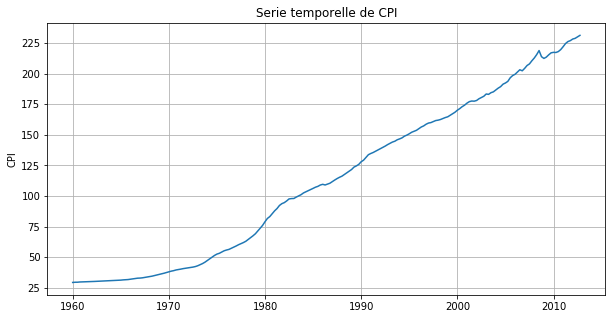

In [4]:
plt.figure(figsize=(10,5))
plt.plot(pd.to_datetime(df['DATE']),df['CPI'])
plt.grid()
plt.ylabel('CPI')
plt.title('Serie temporelle de CPI')
plt.show()

## Ajustement au terme de tendance linéaire-quadratique-log-exponentielle

In [5]:
def lin(x):
    return x

def quad(x):
    return x.pow(2)

def log(x):
    return np.log(x)

def exp(x):
    return np.exp(x)

In [6]:
def tendance_plot(df,ll):
    const = pd.Series(np.ones(df.shape[0]))
    X = pd.concat([const,pd.Series(df.index)+1],axis=1)
    y = df['CPI']
    plt.figure(figsize=(15,20))
    for i,func in enumerate(ll):
        model = sm.OLS(y,func(X))
        results = model.fit()
        ol = results.predict(func(X))
        plt.subplot(4,2,i+1)
        plt.plot(y)
        plt.plot(ol)
        plt.grid('true')
        plt.title('Tendance '+ func.__name__)
    plt.show()

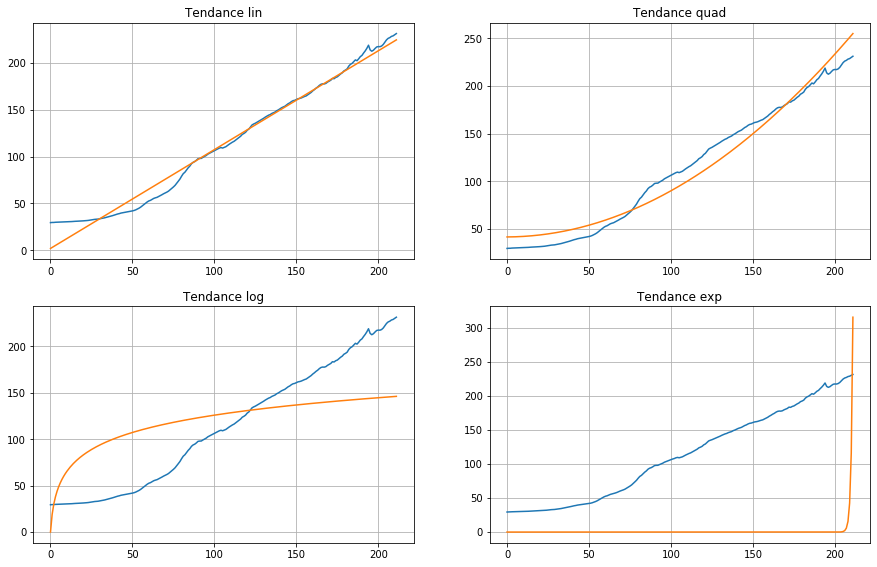

In [7]:
tendance_plot(df,[lin,quad,log,exp])

In [8]:
def residus_plot(df,ll):
    const = pd.Series(np.ones(df.shape[0]))
    X = pd.concat([const,pd.Series(df.index)+1],axis=1)
    y = df['CPI']
    plt.figure(figsize=(15,20))
    for i,func in enumerate(ll):
        
        model = sm.OLS(y,func(X))
        results = model.fit()
        o1 = results.resid
        plt.subplot(4,2,i+1)
        plt.plot(o1)
        plt.grid('true')
        plt.title('Résidus '+ func.__name__)
    plt.show()

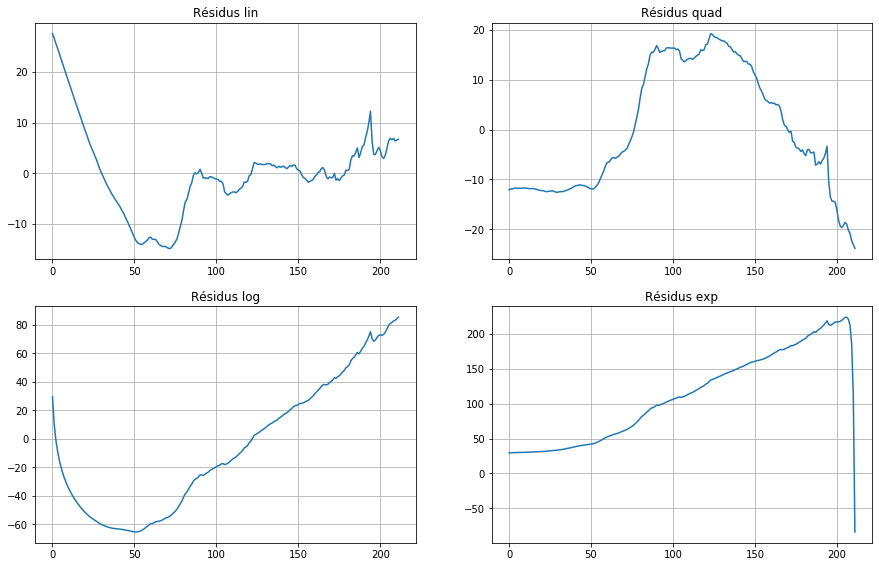

In [9]:
residus_plot(df,[lin,quad,log,exp])

CPI n'est pas stationnaire, on voit clairement une tendance dans son évolution.  
Quelque soit les tendances que nous avons regardé, nous n'avons pas réussi à bien stationnariser CPI. Aucun des résidus n'est stationnaire, donc aucune des transformations ne permet d'obtenir de bons modèles.  
La meilleure stationnarisation provient de la forme linéaire.

## 3. Stationnariser la série de CPI en utilisant une moyenne mobile centrée 5x5

Une moyenne mobile centrée 5x5 signifie l'application d'une moyenne mobile de 5, puis à nouveau sur le résultat trouvé une moyenne mobile de 5.

### 1ère moyenne mobile centrée 5:

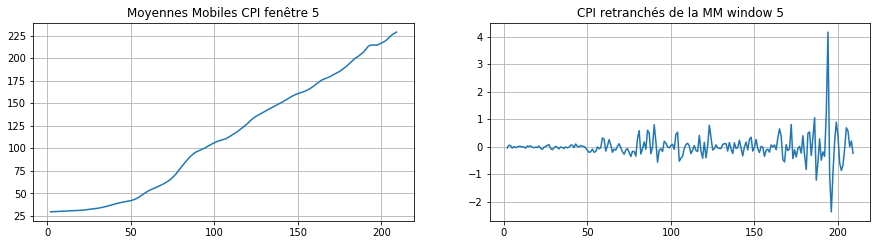

In [10]:
t2= df['CPI'].rolling(window=5, center=True).mean()
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.grid()
plt.title('Moyennes Mobiles CPI fenêtre 5')
plt.plot(t2)


o2= df['CPI']-t2
plt.subplot(2,2,2)
plt.grid()
plt.title('CPI retranchés de la MM window 5')
plt.plot(o2)
plt.show()

__Commentaires:__ La déduction des moyennes mobiles de fenêtre 5, et ce des CPI, ne permet pas d'obtenir la stationarité, dans la mesure où on obtient un processus stationnaire en moyenne, mais non stationnaire en variance

### 2ème moyenne mobile centrée 5:

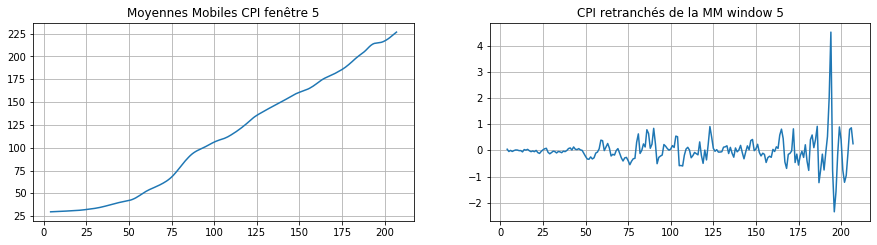

In [11]:
t3=t2.rolling(window=5, center=True).mean()
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.grid()
plt.title('Moyennes Mobiles CPI fenêtre 5')
plt.plot(t3)

o3=df['CPI']-t3
plt.subplot(2,2,2)
plt.grid()
plt.title('CPI retranchés de la MM window 5')
plt.plot(o3)
plt.show()

__Commentaires:__ idem, la déduction des moyennes mobiles de fenêtre 5x5, et ce des CPI, ne permet pas d'obtenir la stationarité, dans la mesure où on obtient un processus stationnaire en moyenne, mais non stationnaire en variance.

## 4. Calculer inf, le taux d’inflation à partir de la variable CPI.

$$
Inf(t) = \frac{CPI(t) - CPI(t-1)}{CPI(t-1)}
$$

In [12]:
inf = [(df['CPI'][i] - df['CPI'][i-1])/df['CPI'][i-1] for i in range (1,df.shape[0])]

## Faire un graphique dans le temps de inf.

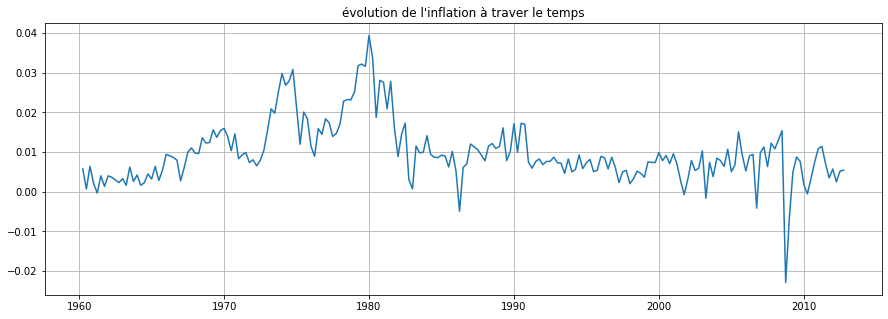

In [13]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(pd.Series(pd.to_datetime(df['DATE']))[1:],inf)
plt.title("évolution de l'inflation à traver le temps")
plt.show()

## Commentez.

- Les pics > 0 correspondent à des chocs pétroliers (en 1973 et 1979)
- Les pic < 0 de 2008 correspond à la crise des subprimes, celui de 1987 est dû au krach boursier
- Dans les autres phases, l'inflation semble être contrôlée

La série temporelle de Inf: 
- ne présente pas de tendance temporelle claire ni de saisonnalité 
- n'est pas stationnaire (pas de moyenne constante, ni de variance constante)

## 5. Interpréter l'autocorrélogramme et l'autocorrélogrammes partiels de inf. Quelle est la différence entre ces deux graphiques ?

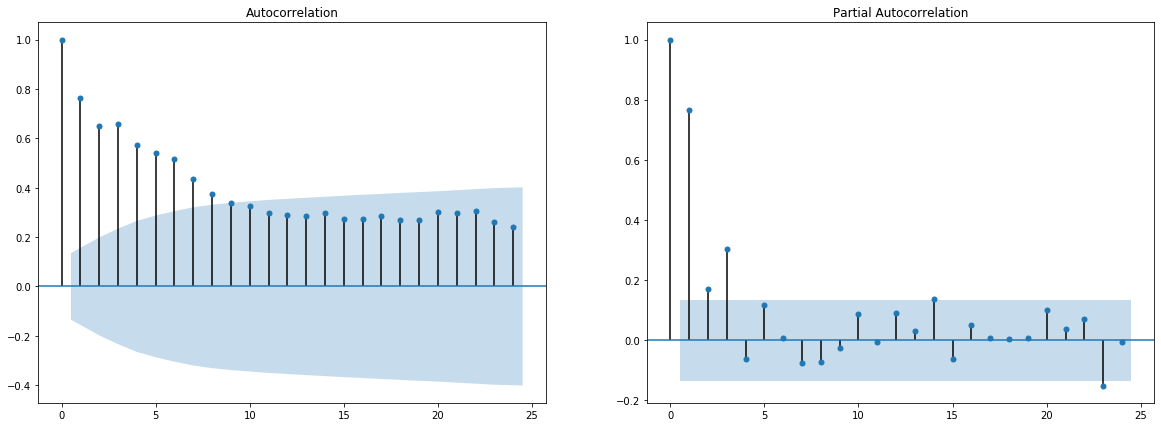

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

fig = plot_acf(np.asarray(inf), ax=axes[0]) 
fig = plot_pacf(np.asarray(inf), ax=axes[1])

=> Le diagramme __ACF__ montre une auto-corrélation significative d'ordre 8 pour un modèle MA. De plus l'auto-corrélation diminue avec le temps, ce qui veut dire que l'impact du passé est limité.<br>
=> Le diagramme __PACF__ montre une auto-corrélation significative d'ordre 3 pour un modèle AR.


La différence entre ACF et PACF: le PACF montre la corrélation entre X et X(t-k) débarassé de la corrélation avec les autres lags.

L'absence de stationnarité de notre CPI nous fait douter de la pertinence de la modélisation type ARIMA.

On choisirait alors le modèle AR(3) pour sa simplicité.

## 6. Quelle est la différence entre la stationnarité et l'ergodicité ? Pourquoi a-t-on besoin de ces deux conditions.

__Stationarité:__ Signifie que la distribution de la variable ne dépend pas du temps. La distribution jointe de (ys+1, ys+2, ..., ys+T) ne dépend pas de s. Le futur et le passé se ressemblent.  
__Stationarité Faible:__ Signifie que la série ne change pas de moyenne, ni de variance, tout au long du temps<br> <br> __Ergodicité:__  La moyenne temporelle converge vers la moyenne spatiale (héorème ergodique de Birkhoff). Celà signifie que les caractéristiques que nous allons apprendre en temporelle pourront être retrouvés/utilisés dans une nouvelle réalisation du processus.
Pratiquement, l'ergodicité s'évalue qualitativement sur le jeu de données, et ne peut être estimée que qualitativement et vérifiée tout au long du temps. Tout processus ergodique oublie les conditions initiales : l’auto-corrélation d’ordre k tend vers 0 lorsque k tend vers l’infini. <br>  

__Différence entre stationnarité et ergodicité:__ Un phénomène ergodique est stationnaire. La réciproque est fausse. 
La stationnarité ne suffit pas pour garantir la répétabilité de notre phénomène sur une autre réalisation de la série temporelle.

## Expliquez le terme "spurious regression"

<br> __Spurious Regression:__ Désigne une situation dans laquelle l'utilisation de séries temporelles non stationnaires dans une régression linéaire fait apparaître des résultats erronés, trop optimistes, qui font croire à une relation entre les variables alors que ce n'est pas le cas

## 7. Faire le test Augmented Dickey Fuller pour inf en utilisant le critère AIC pour déterminer le nombre de lags à inclure. Commenter

Test de racine unitaire:  
H0: $\gamma = 0$ => Non Stationnarité   
H1: $\gamma < 0$ => Stationnarité   

In [15]:
#Dickey Fuller sur inf
stat = adfuller(inf, autolag='AIC',regression='nc')
#print(f"le test de Dicken-Fulley donne une valeur de {stat[0]}, avec une p-value de {stat[1]} très petite")
print(f'Statistique {stat[0]}')
print(f'P-value {stat[1]}')
print(f'Nombre de lags utilisés pour stationariser la série: {stat[2]}')

Statistique -1.420349692375097
P-value 0.14499315775171723
Nombre de lags utilisés pour stationariser la série: 4


In [16]:
#Dickey Fuller sur inf
stat = adfuller(inf, autolag='AIC',regression='c')
#print(f"le test de Dicken-Fulley donne une valeur de {stat[0]}, avec une p-value de {stat[1]} très petite")
print(f'Statistique {stat[0]}')
print(f'P-value {stat[1]}')
print(f'Nombre de lags utilisés pour stationariser la série: {stat[2]}')

Statistique -2.9190558143371668
P-value 0.04317651687155444
Nombre de lags utilisés pour stationariser la série: 2


In [17]:
#Dickey Fuller sur inf
stat = adfuller(inf, autolag='AIC',regression='ct')
#print(f"le test de Dicken-Fulley donne une valeur de {stat[0]}, avec une p-value de {stat[1]} très petite")
print(f'Statistique {stat[0]}')
print(f'P-value {stat[1]}')
print(f'Nombre de lags utilisés pour stationariser la série: {stat[2]}')

Statistique -3.1334995610356007
P-value 0.09848521133714605
Nombre de lags utilisés pour stationariser la série: 2


In [18]:
#Dickey Fuller sur inf
stat = adfuller(inf, autolag='AIC',regression='ctt')
#print(f"le test de Dicken-Fulley donne une valeur de {stat[0]}, avec une p-value de {stat[1]} très petite")
print(f'Statistique {stat[0]}')
print(f'P-value {stat[1]}')
print(f'Nombre de lags utilisés pour stationariser la série: {stat[2]}')

Statistique -3.366399828975888
P-value 0.15057742722827855
Nombre de lags utilisés pour stationariser la série: 2


__Commentaires:__ Au vu de la série temporelle CPI (pas de tendance temporelle linéaire une moyenne non nulle), nous choisissons la configuration regression='c'. Le test de ADF nous montre que la série n'était pas stationnaire, et qu'il a fallu introduire deux délais, à t-1 et t-2.
cela dit, le nombre de lag est différent de celui qui est rendu par le PACF ci-dessus.

## 8. Proposer une modélisation AR(p) de inf, en utilisant tous les outils vus au cours.

In [19]:
aic = {}
bic = {}

for i in range(1,20):
    
    mdl = smt.AR(inf).fit(maxlag=i)
    #print(mdl.params)
    aic[i] = mdl.aic
    bic[i] = mdl.bic

print(f'lags pour AIC {min(aic, key=aic.get)}')
print(f'lags pour BIC {min(bic, key=bic.get)}')

lags pour AIC 3
lags pour BIC 3


On choisit le nombre de lags avec les critères AIC et BIC.  Nous trouvons que 3 lags minimise à la fois AIC et BIC. Ces résultats sont similaires aux lags rendus par le PACF

# 9. Estimer le modèle de la courbe de Philips qui explique le taux de chômage (Unemp) en fonction du taux d’inflation courant et une constante.

In [20]:
b = df['Unemp'].loc[1:]

a = pd.Series(inf)
a.index = range(1,len(a)+1)
c = pd.DataFrame(np.ones(b.shape[0]+1)).drop(0)

Z = pd.concat([a,b,c],axis=1)
Z.columns = ['inf','Unemp','const']

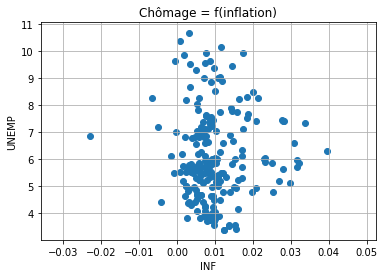

In [21]:
plt.scatter(Z['inf'],Z['Unemp'])
plt.grid()
plt.xlabel('INF')
plt.ylabel('UNEMP')
plt.title('Chômage = f(inflation)')
plt.show()

In [22]:
X = Z[['inf','const']]
y = pd.DataFrame(Z['Unemp'])
n,k = X.shape
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01214
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.912
Time:                        21:42:20   Log-Likelihood:                -400.28
No. Observations:                 211   AIC:                             804.6
Df Residuals:                     209   BIC:                             811.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
inf            1.5908     14.440      0.110      0.9

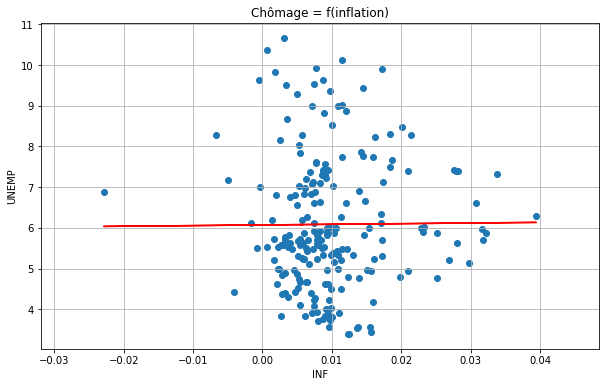

In [23]:
plt.figure(figsize=(10,6))

plt.scatter(Z['inf'],Z['Unemp'])
plt.plot(Z['inf'],results.fittedvalues,color='r')
plt.grid()
plt.xlabel('INF')
plt.ylabel('UNEMP')
plt.title('Chômage = f(inflation)')
plt.show()

__Commentaires:__ Les résultats de l'OLS montrent que, l'influence de l'inflation sur le chômage est d'1.6 point, ceci-dit celle-ci n'est pas significative relativement à la pvalue de 0.912. On en déduit que le chômage n'est pas impacté par l'inflation courante. On verra plus tard, ci-dessous, l'influence des lags plus anciens, sur le chômage.

# 10. Tester l’autocorrélation des erreurs.

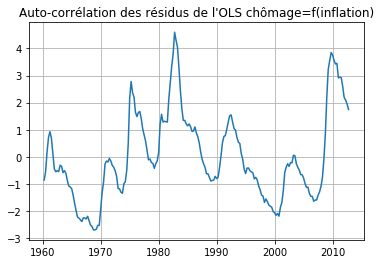

In [24]:
plt.plot(pd.Series(pd.to_datetime(df['DATE']))[1:],results.resid)
plt.grid()
plt.title("Auto-corrélation des résidus de l'OLS chômage=f(inflation)")
plt.show()

__Commentaires:__ On voit bien que le tracé des résidus présente une saisonalité, ainsi qu'une variance non constante à travers le temps.

### Test de l'auto-corrélation des résidus avec OLS entre e(t) et e(t-1)

In [25]:
X1 = np.asarray(results.resid)
y1 = X1[1:]

In [26]:
#Sans intercept
model1 = sm.OLS(y1,X1[:-1])
result1 = model1.fit()
print(result1.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              4557.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):                   6.88e-144
Time:                        21:42:20   Log-Likelihood:                         -70.409
No. Observations:                 210   AIC:                                      142.8
Df Residuals:                     209   BIC:                                      146.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

=> Nous rejettons l'hypothèse nulle H0, il y a corrélation entre les erreurs, donc il s'agit d'une corrélation résiduelle que nous allons tenter d'éliminer avec les méthodes du cours.

### Durbin Watson

In [27]:
s = durbin_watson(results.resid)
s

0.04419412807471199

__=> Commentaire Durbin-Watson:__ Selon la statistique de Durbin-Watson, il y a forte corrélation positive, car celle-ci est proche de 0. Le coefficient de Durbin-Watson est cohérent avec le coefficient obtenu dans l'OLS.

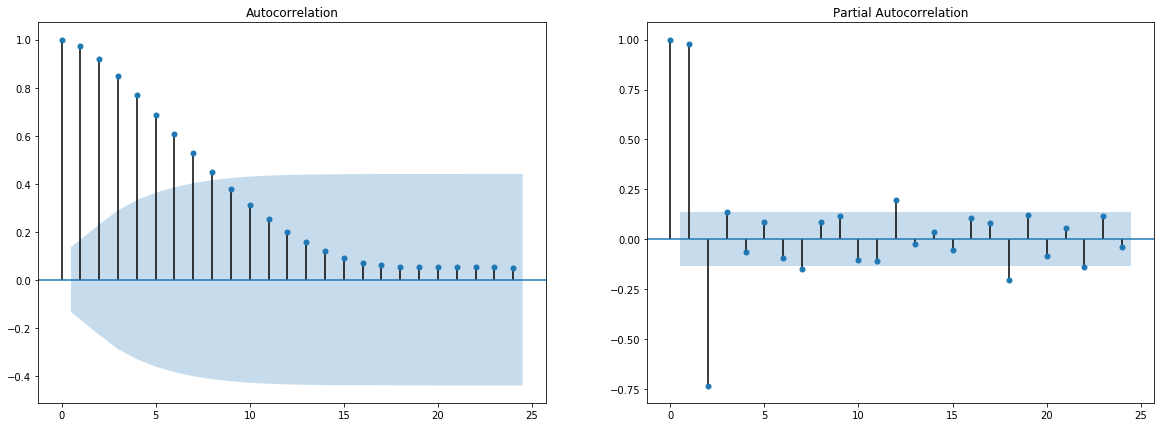

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

fig = plot_acf(results.resid, ax=axes[0]) 
fig = plot_pacf(results.resid, ax=axes[1])

=> Le pacf montre aussi clairement plusieurs lags, ie l'auto-corrélation des erreurs

## 11. Corriger l’autocorrélation des erreurs par la méthode vue en cours.

$y_{t} - \rho y_{t-1} = (1 - \rho) \beta_0 + \beta_1(x_t - \rho x_{t-1}) + e_t, t \geq 2 $

In [29]:
rho = result1.params[0]

In [30]:
Yb = y[:-1].reset_index(drop=True) - rho*y[1:].reset_index(drop=True)

Xb = X.iloc[:-1,0].reset_index(drop=True) - rho*X.iloc[1:,0].reset_index(drop=True)

cb = (1-rho)*np.ones(Xb.shape[0]).reshape(-1,1)

Xbb = np.column_stack((cb,Xb))

In [31]:
modl = sm.OLS(Yb,Xbb)
resul = modl.fit()
print(resul.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5.142
Date:                Sun, 12 Apr 2020   Prob (F-statistic):             0.0244
Time:                        21:42:20   Log-Likelihood:                -66.420
No. Observations:                 210   AIC:                             136.8
Df Residuals:                     208   BIC:                             143.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.5722      1.147      4.856      0.0

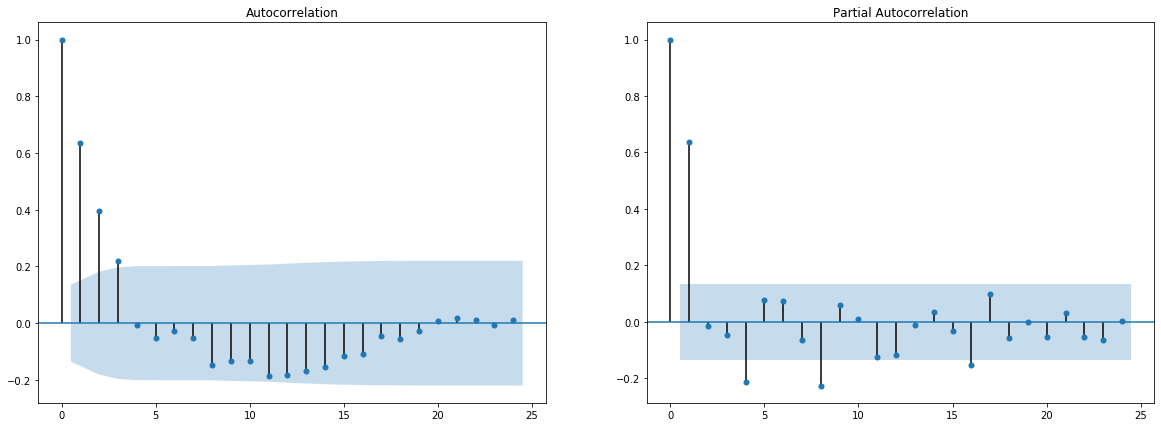

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

fig = plot_acf(resul.resid, ax=axes[0]) 
fig = plot_pacf(resul.resid, ax=axes[1])

=> __Commentaire:__ le pacf montre une auto-corrélation significative à l'ordre 1, ainsi que des lags plus lointains dans le passé, 4/8/11/12, qu'on pourrait vérifier avec des tests de Fischer

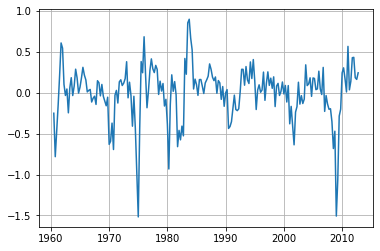

In [33]:
plt.plot(pd.Series(pd.to_datetime(df['DATE']))[2:],resul.resid)
plt.grid()
plt.show()

__On a nettement amélioré la stationarité des erreurs__

In [34]:
s1 = durbin_watson(resul.resid)
s1

0.7266368524498257

__On a nettement amélioré l'auto-corrélation des erreurs, avec une stat de DW s'approchant de 2__

# 12. Tester la stabilité de la relation chômage-inflation sur deux sous-périodes de taille identique.

H0: même structure sur les deux sous périodes (même coefficients de régressions entre modèle 'total' et les deux autres sous régression) 

In [35]:
dtf = pd.to_datetime(df['DATE'])
mask = dtf > dtf.quantile(0.5)
dtf.quantile(0.5)

Timestamp('1986-05-16 12:00:00')

In [36]:
# OLS contraint sur la première sous partie des données

X12 = pd.DataFrame(np.column_stack((np.ones(len(inf)),inf)))[mask]
y12 = df[1:]['Unemp'].reset_index(drop=True)[mask]

modl12 = sm.OLS(y12,X12)
result12 = modl12.fit()
#print(result12.summary())
u12 = result12.resid
SSR12 = u12.T.dot(u12) 

In [37]:
# OLS contraint sur la seconde sous partie des données

X13 = pd.DataFrame(np.column_stack((np.ones(len(inf)),inf)))[~mask]
y13 = df[1:]['Unemp'].reset_index(drop=True)[~mask]

modl13 = sm.OLS(y13,X13)
result13 = modl13.fit()
#print(result13.summary())
u13 = result13.resid
SSR13 = u13.T.dot(u13)

In [38]:
# OLS non contraint
u = results.resid
SSR = u.T.dot(u)

In [39]:
#Calcul des dégrés de libertés
ddl1 = k
ddl2 = n - 2*(k)

In [40]:
F = ((SSR - (SSR13 + SSR12))/ddl1) / ((SSR13 + SSR12) / ddl2)
print(f'statistique de test:{F}')
print(f'p-value:{f.sf(F,ddl1,ddl2)}')

statistique de test:1.9250391288724475
p-value:0.14847246462104421


__=>Commentaires:__ On ne rejette pas l'hypothèse d'un seul modèle à 5%, on garde l'égalité des coefficients des trois régressions.

# 13. Faites les tests changement de structure de Chow et détecter le point de rupture.

In [41]:
dtf = pd.to_datetime(df['DATE'])
tt = df.shape[0]
pvalues = {}
fvalues = {}

# OLS non contraint
SSR = results.ssr

#Calcul des dégrés de libertés
d1 = k
d2 = n - 2*(k)

for i in range(1,tt-1):
    
    #print(i)
    mask = dtf > dtf.quantile(i/tt)

    # OLS contraint sur la première sous partie des données

    X12 = pd.DataFrame(np.column_stack((np.ones(len(inf)),inf)))[mask]
    y12 = df[1:]['Unemp'].reset_index(drop=True)[mask]

    modl12 = sm.OLS(y12,X12)
    result12 = modl12.fit()
    SSR12 = result12.ssr

    # OLS contraint sur la seconde sous partie des données

    X13 = pd.DataFrame(np.column_stack((np.ones(len(inf)),inf)))[~mask]
    y13 = df[1:]['Unemp'].reset_index(drop=True)[~mask]

    modl13 = sm.OLS(y13,X13)
    result13 = modl13.fit()    
    SSR13 = result13.ssr   
    
    
    F = ((SSR - (SSR13 + SSR12))/d1) / ((SSR13 + SSR12) / d2)
    #print(F)
    pvalues[i] = f.sf(F,d1,d2)
    fvalues[i] = F

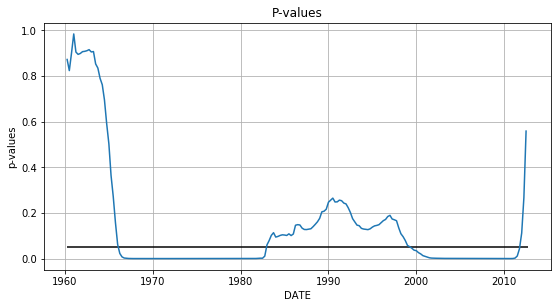

In [42]:
dd = pd.to_datetime(df['DATE'])

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(dd[1:211],list(pvalues.values()))
plt.grid()
plt.hlines(0.05,dd[1],dd[211])
plt.xlabel('DATE')
plt.ylabel('p-values')
plt.title('P-values')

plt.show()

Nous pouvons dire qu'il y a changement de structure avant les années 70 et les années 2000.

Nous pouvons dire qu'entre les années 1983 et 2000, les situations 'vécues' sont équilibrées avant / après.

# 14. Estimer la courbe de Philips en supprimant l'inflation courante des variables explicatives mais en ajoutant les délais d’ordre 1, 2, 3 et 4 de l’inflation et du chômage.  Faire le test de Granger de non causalité de l’inflation sur le chômage. Donnez la p-valeur.

H0: variables lags de inf n'ont pas d'impact sur le chomâge

In [43]:
#Variables inflation lags

inf_1 = pd.DataFrame(inf,columns=['inf_1']).shift(1)
inf_2 = pd.DataFrame(inf,columns=['inf_2']).shift(2)
inf_3 = pd.DataFrame(inf,columns=['inf_3']).shift(3)
inf_4 = pd.DataFrame(inf,columns=['inf_4']).shift(4)

unemp = pd.DataFrame(df['Unemp'][1:]).reset_index(drop=True)

#Variables Unemp lags

unemp_1 = unemp.shift(1).rename(columns={'Unemp': 'Unemp_1'})
unemp_2 = unemp.shift(2).rename(columns={'Unemp': 'Unemp_2'})
unemp_3 = unemp.shift(3).rename(columns={'Unemp': 'Unemp_3'})
unemp_4 = unemp.shift(4).rename(columns={'Unemp': 'Unemp_4'})

# Modèle non contraint
X5 = pd.concat([inf_1,inf_2,inf_3,inf_4,unemp_1,unemp_2,unemp_3,unemp_4],axis=1)[4:].reset_index(drop=True)

# Modèle contraint
X6 = pd.concat([unemp_1,unemp_2,unemp_3,unemp_4],axis=1)[4:].reset_index(drop=True)

y5 = pd.DataFrame(df['Unemp'][1:])[4:].reset_index(drop=True)

In [44]:
#OLS sur modèle non contraint
modl5 = sm.OLS(y5,sm.add_constant(X5))
result5 = modl5.fit()
u5 = result5.resid
n5,k5 = X5.shape

SSR5n = u5.T.dot(u5)
SSR5n

11.587384278415238

In [45]:
#OLS sur modèle contraint
modl6 = sm.OLS(y5,sm.add_constant(X6))
result6 = modl6.fit()
u6 = result6.resid

SSR6c = u6.T.dot(u6)
SSR6c

12.476148169307272

In [46]:
#Statistique de Fischer

F5 = ((SSR6c - SSR5n)/4) / ((SSR5n) / (n5 - k5))
print(f'statistique de test:{F5}')
print(f'p-value:{f.sf(F5,4,n5-k5)}')

statistique de test:3.815874446681075
p-value:0.005180621994312998


__Commentaire:__ Avec une p-value de 0.00518.<br> __H0:__ inflation a un effet nul sur le chômage. On rejette __H0__.<br> __Conclusion:__ L'inflation a un effet sur le chômage.

On regarde le test de Granger sur 5 lags:

In [47]:
granger(pd.concat([pd.DataFrame(inf),df['Unemp'][1:].reset_index(drop=True)],axis=1),maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2292  , p=0.6326  , df_denom=207, df_num=1
ssr based chi2 test:   chi2=0.2325  , p=0.6296  , df=1
likelihood ratio test: chi2=0.2324  , p=0.6297  , df=1
parameter F test:         F=0.2292  , p=0.6326  , df_denom=207, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7309  , p=0.0256  , df_denom=204, df_num=2
ssr based chi2 test:   chi2=7.6447  , p=0.0219  , df=2
likelihood ratio test: chi2=7.5082  , p=0.0234  , df=2
parameter F test:         F=3.7309  , p=0.0256  , df_denom=204, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2342  , p=0.0001  , df_denom=201, df_num=3
ssr based chi2 test:   chi2=22.4583 , p=0.0001  , df=3
likelihood ratio test: chi2=21.3266 , p=0.0001  , df=3
parameter F test:         F=7.2342  , p=0.0001  , df_denom=201, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8874  , p=0.0009  

{1: ({'ssr_ftest': (0.2292233348954234, 0.6326056425732294, 207.0, 1),
   'ssr_chi2test': (0.23254541221274838, 0.629642833257049, 1),
   'lrtest': (0.232416751546225, 0.6297376051233574, 1),
   'params_ftest': (0.22922333489545813, 0.6326056425732123, 207.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.7309243937348344, 0.025621853289764348, 204.0, 2),
   'ssr_chi2test': (7.6447372381429455, 0.02187592374971908, 2),
   'lrtest': (7.508242316961059, 0.02342102493624292, 2),
   'params_ftest': (3.7309243937352514, 0.0256218532897542, 204.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.2341723301373, 0.00012387628225605314, 201.0, 3),
   'ssr_chi2test': (22.458326039829227, 5.236619696511566e-05, 3),
   'lrtest': (21.32664940589939, 9.004750278816249e-05, 3),
   'params_ftest': (7.234172330137284, 0.00012387628225605593, 201.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

Les résultats de Granger sont cohérents avec le fait que Inf(t) et inf(t-1) n'expliquent pas à eux seuls le chomâge, par contre tous les lags ensemble Inf(t-1), Inf(t-2), Inf(t-3) et Inf(t-4) expliquent le chômage. Nous avons comme un effet 'tampon', il faut un temps avant que les effets de l'inflation atteignent le chômage.

# 15. Représentez graphiquement les délais distribués et commentez. Calculer l’impact à long de terme de l’inflation sur le chômage.

In [48]:
inf_df = pd.DataFrame(inf)[4:].reset_index(drop=True)
X15 = pd.concat([inf_df,X5.iloc[:,:4]], axis=1)
X15.columns=['inf','inf1','inf2','inf3','inf4']

In [49]:
mod = sm.OLS(df['Unemp'][5:].reset_index(drop=True),sm.add_constant(X15))
res = mod.fit()

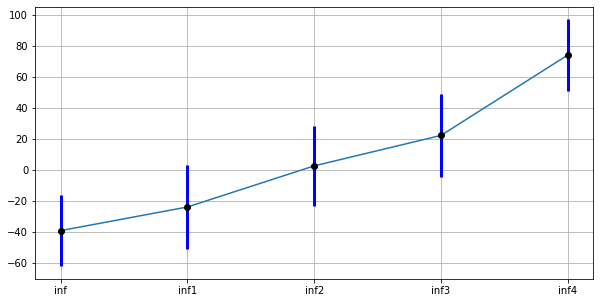

In [50]:
plt.figure(figsize=(10,5))

x = X15.columns=['inf','inf1','inf2','inf3','inf4']
y = res.params[1:]

#result5.cov_HC0
dy = res.bse[1:]
plt.grid()
plt.errorbar(x, y, yerr=dy, fmt='o', color='black',
             ecolor='blue', elinewidth=3, capsize=0);
plt.plot(res.params[1:])

In [51]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     4.650
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           0.000487
Time:                        21:42:22   Log-Likelihood:                -383.05
No. Observations:                 207   AIC:                             778.1
Df Residuals:                     201   BIC:                             798.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7414      0.195     29.504      0.0

Nous avons tracé les effets des délais distributés (immédiat, et dépendant de chaque lag).
Nous pouvons voir que l'effet augmente avec le lag, ce qui signifie que l'inflation 1an avant le temps regardé est la plus influente sur la valeur du chômage.

__Calcul de l'effet long-terme:__

In [52]:
res.params.sum()

40.74798201995448

On remarque que l'effet long terme est positif sur le chômage, donc l'hypothèse de Philips que plus il y a d'inflation, plus il y a de chômage est vraie à long terme.